# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [127]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [128]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)


datetime.datetime(2024, 11, 13, 14, 1, 30, 223694)

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [130]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [131]:
from pathlib import Path

path = Path('../../data/hopsworks-api-key.txt')
content = path.read_text()
print(content)
#print(HOPSWORKS_API_KEY)
print(os.environ)

wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB

environ({'SHELL': '/bin/bash', 'CONDA_EXE': '/opt/conda/bin/conda', '_CE_M': '', 'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE', 'GRPC_FORK_SUPPORT_ENABLED': '0', 'DL_ANACONDA_HOME': '/opt/conda', 'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework', 'GOOGLE_CLOUD_PROJECT': 'id2223group14', 'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh', 'DL_PATH_DEPS': '/opt/deeplearning/deps', 'DL_BIN_PATH': '/opt/deeplearning/bin', 'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog', 'KERNEL_LAUNCH_TIMEOUT': '40', 'BINARIES_PATH': '/opt/deeplearning/binaries', 'PWD': '/home/jupyter/mlfs-book/notebooks/ch03', 'LOGNAME': 'jupyter', 'CONDA_PREFIX': '/opt/conda', 'JPY_SESSION_NAME': '/home/jupyter/mlfs-book/notebooks/ch03/4_air_quality_batch_inference.ipynb', 'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/', 'PACKAGE_SOURCE_CODE_PATH': '/opt/deeplearning/src/third_party', 'JUPYTER_DEPS_PATH': 

## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [132]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

# Retrieve a DataFrame with data from the feature view
feature_view_df = feature_view.get_batch_data()

feature_view_df





Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


,pm25_3day_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,1.193333,2019-12-12 00:00:00+00:00,2.820667,5.599999,17.639999,181.624420,stockholm
1,3.736667,2019-12-13 00:00:00+00:00,2.835250,2.500000,20.371038,146.506561,stockholm
2,5.106667,2019-12-14 00:00:00+00:00,3.449834,8.600000,20.969807,143.838364,stockholm
3,5.566667,2019-12-15 00:00:00+00:00,3.283166,2.900000,12.904882,161.324631,stockholm
4,3.083333,2019-12-16 00:00:00+00:00,2.983167,4.500000,19.799999,239.205124,stockholm
...,...,...,...,...,...,...,...
1787,0.533333,2024-11-04 00:00:00+00:00,4.095667,0.000000,16.928614,279.599670,stockholm
1788,0.556667,2024-11-05 00:00:00+00:00,5.524834,0.000000,17.533146,279.356049,stockholm
1789,0.756667,2024-11-06 00:00:00+00:00,5.051917,0.000000,16.862455,280.329712,stockholm
1790,1.046667,2024-11-07 00:00:00+00:00,5.187334,0.000000,14.178927,293.139465,stockholm


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [133]:
mr = project.get_model_registry()

#Change name to get other model
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model2",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [134]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.420078E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [135]:

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date'])
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
7,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,stockholm
6,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,stockholm
0,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,stockholm
2,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,stockholm
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,stockholm
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,stockholm
8,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,stockholm
1,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,stockholm
3,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,stockholm


In [136]:
aq_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
aq_df = aq_fg.read()
aq_df = aq_df.sort_values(by=['date'])
aq_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.89s) 


,date,pm25,pm25_3day_mean,country,city,street,url
315,2019-12-12 00:00:00+00:00,8.75,1.193333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
287,2019-12-13 00:00:00+00:00,5.09,3.736667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1453,2019-12-14 00:00:00+00:00,2.86,5.106667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
475,2019-12-15 00:00:00+00:00,1.30,5.566667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
89,2019-12-16 00:00:00+00:00,1.29,3.083333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
...,...,...,...,...,...,...,...
93,2024-11-04 00:00:00+00:00,0.57,0.533333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1496,2024-11-05 00:00:00+00:00,1.20,0.556667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
812,2024-11-06 00:00:00+00:00,1.37,0.756667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
52,2024-11-07 00:00:00+00:00,0.60,1.046667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912


In [137]:


predictions = []

# Get the last 3 days of PM2.5 values (including today) for the rolling mean calculation
last_pm25_values = list(aq_df['pm25'].iloc[-3:])

for i, future_row in batch_data.iterrows():
    rolling_pm25_series = pd.Series(last_pm25_values)
    pm25_3day_mean = rolling_pm25_series.rolling(window=3).mean().iloc[-1]
    
    input_features = [
        future_row['temperature_2m_mean'],
        future_row['precipitation_sum'],
        future_row['wind_speed_10m_max'],
        future_row['wind_direction_10m_dominant'],
        pm25_3day_mean
    ]
    
    predicted_pm25 = retrieved_xgboost_model.predict([input_features])[0]
    
    predictions.append({
        'date': future_row['date'],
        'predicted_pm25': predicted_pm25,
        'pm25_3day_mean': pm25_3day_mean
    })
    
    last_pm25_values.append(predicted_pm25)
    if len(last_pm25_values) > 3:
        last_pm25_values.pop(0)
        
    predictions_df = pd.DataFrame(predictions)

#print(predictions_df[['date', 'predicted_pm25', 'pm25_3day_mean']])

merged_df = pd.merge(predictions_df, batch_data, on='date', how='left')
merged_df

,date,predicted_pm25,pm25_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-14 00:00:00+00:00,4.304447,2.323333,6.00,0.0,15.124284,321.766113,stockholm
1,2024-11-15 00:00:00+00:00,4.362710,3.301482,6.85,0.0,9.470120,261.253906,stockholm
2,2024-11-16 00:00:00+00:00,3.418697,4.555719,10.10,0.0,25.809765,239.858688,stockholm
3,2024-11-17 00:00:00+00:00,3.717334,4.028618,5.00,0.6,20.371038,223.567963,stockholm
4,2024-11-18 00:00:00+00:00,3.644867,3.832914,4.60,0.0,14.044615,268.531219,stockholm
5,2024-11-19 00:00:00+00:00,2.020954,3.593633,1.45,0.0,4.334974,311.633453,stockholm
6,2024-11-20 00:00:00+00:00,3.618222,3.127719,3.30,1.4,23.402769,89.118622,stockholm
7,2024-11-21 00:00:00+00:00,4.010648,3.094681,6.90,1.1,11.367109,259.045990,stockholm
8,2024-11-22 00:00:00+00:00,2.473665,3.216608,1.50,1.8,30.302078,256.954346,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [138]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 7 to 3
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(4), object(1)
memory usage: 360.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [139]:
merged_df['street'] = street
merged_df['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
merged_df['days_before_forecast_day'] = range(1, len(merged_df)+1)
merged_df = merged_df.sort_values(by=['date'])
merged_df

,date,predicted_pm25,pm25_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,4.304447,2.323333,6.00,0.0,15.124284,321.766113,stockholm,Radarvagen,sweden,1
1,2024-11-15 00:00:00+00:00,4.362710,3.301482,6.85,0.0,9.470120,261.253906,stockholm,Radarvagen,sweden,2
2,2024-11-16 00:00:00+00:00,3.418697,4.555719,10.10,0.0,25.809765,239.858688,stockholm,Radarvagen,sweden,3
3,2024-11-17 00:00:00+00:00,3.717334,4.028618,5.00,0.6,20.371038,223.567963,stockholm,Radarvagen,sweden,4
4,2024-11-18 00:00:00+00:00,3.644867,3.832914,4.60,0.0,14.044615,268.531219,stockholm,Radarvagen,sweden,5
5,2024-11-19 00:00:00+00:00,2.020954,3.593633,1.45,0.0,4.334974,311.633453,stockholm,Radarvagen,sweden,6
6,2024-11-20 00:00:00+00:00,3.618222,3.127719,3.30,1.4,23.402769,89.118622,stockholm,Radarvagen,sweden,7
7,2024-11-21 00:00:00+00:00,4.010648,3.094681,6.90,1.1,11.367109,259.045990,stockholm,Radarvagen,sweden,8
8,2024-11-22 00:00:00+00:00,2.473665,3.216608,1.50,1.8,30.302078,256.954346,stockholm,Radarvagen,sweden,9


In [140]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[ns, UTC]
 1   predicted_pm25               9 non-null      float32            
 2   pm25_3day_mean               9 non-null      float64            
 3   temperature_2m_mean          9 non-null      float32            
 4   precipitation_sum            9 non-null      float32            
 5   wind_speed_10m_max           9 non-null      float32            
 6   wind_direction_10m_dominant  9 non-null      float32            
 7   city                         9 non-null      object             
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

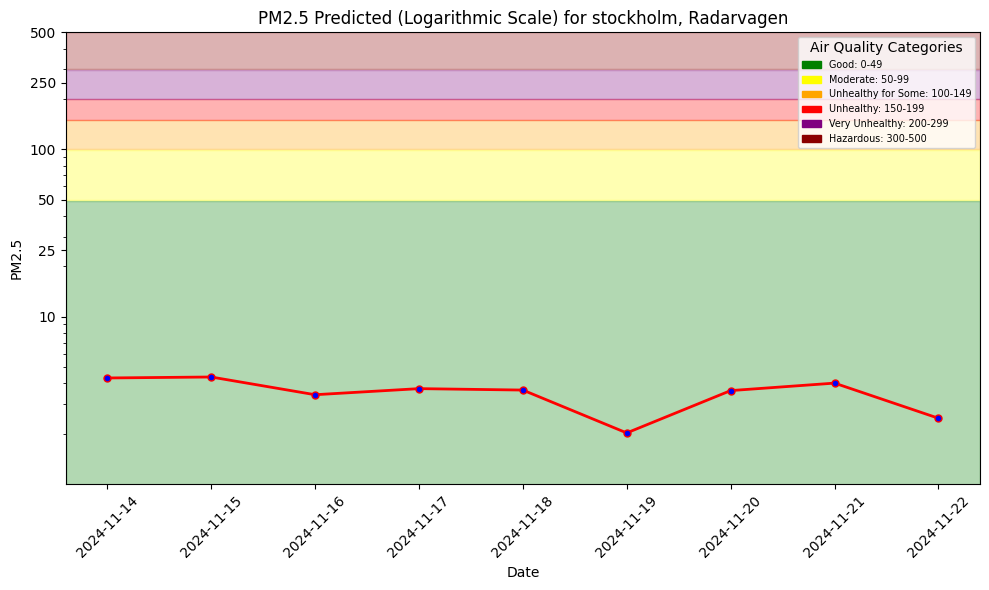

In [141]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, merged_df, file_path)
plt.show()

In [142]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)


In [143]:
monitor_fg.insert(merged_df, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1163414/fs/1154117/fg/1346960


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163414/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f9ad059e770>, None)

In [144]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,date,predicted_pm25,pm25_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,4.304447,2.323333,6.0,0.0,15.124284,321.766113,stockholm,Radarvagen,sweden,1


In [145]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,pm25,pm25_3day_mean,country,city,street,url
0,2024-10-15 00:00:00+00:00,0.80,1.343333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1,2022-08-14 00:00:00+00:00,1.83,1.813333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
2,2023-08-08 00:00:00+00:00,0.93,5.910000,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
3,2024-07-22 00:00:00+00:00,6.85,2.996667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
4,2023-03-04 00:00:00+00:00,0.60,0.766667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
...,...,...,...,...,...,...,...
1787,2022-04-03 00:00:00+00:00,0.70,1.466667,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1788,2023-02-26 00:00:00+00:00,1.00,1.583333,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1789,2023-06-06 00:00:00+00:00,1.80,0.920000,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912
1790,2024-01-06 00:00:00+00:00,2.20,1.480000,sweden,stockholm,Radarvagen,https://api.waqi.info/feed/A58912


In [167]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]




hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])


# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
#    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitoring_df, retrieved_xgboost_model)
#air_quality_df
#monitoring_df


from datetime import datetime

# Fabricate today's date and PM2.5 values (adjust values as needed)
today_date = datetime.now().date()
fabricated_predicted_pm25 = 3.5  # Replace with your chosen predicted PM2.5 value
fabricated_actual_pm25 = 7  # Replace with your chosen actual PM2.5 value

# Create a new DataFrame row for today
fabricated_row = pd.DataFrame({
    'date': [today_date],
    'predicted_pm25': [fabricated_predicted_pm25],
    'pm25': [fabricated_actual_pm25]
})

# Append the fabricated row to hindcast_df
hindcast_df = pd.concat([hindcast_df, fabricated_row], ignore_index=True)

# Ensure the 'date' column is in datetime format for consistency
hindcast_df['date'] = pd.to_datetime(hindcast_df['date'])



#preds_df
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-13,3.5,7.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

        date  predicted_pm25  pm25
0 2024-11-13             3.5   7.0


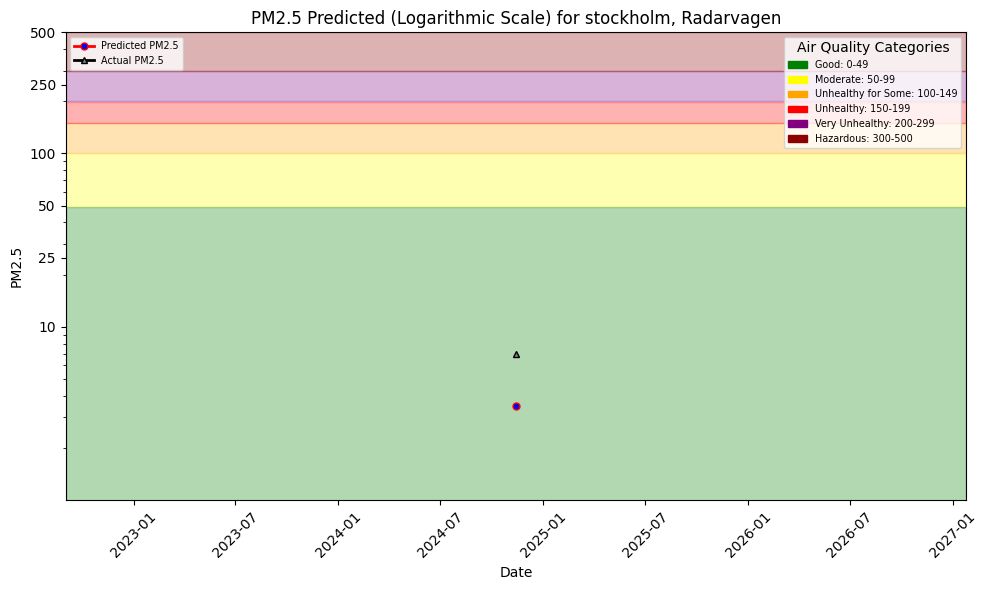

In [168]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
print(hindcast_df)

plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---